In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Use sql to find max date
engine.execute("select max(date) from measurement").fetchall()


[('2017-08-23',)]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
query_date = dt.datetime.strptime(max_date, '%Y-%m-%d')  - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= query_date).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df['date'] = df['date'].astype('datetime64[ns]')
df.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_df = df.sort_index()
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


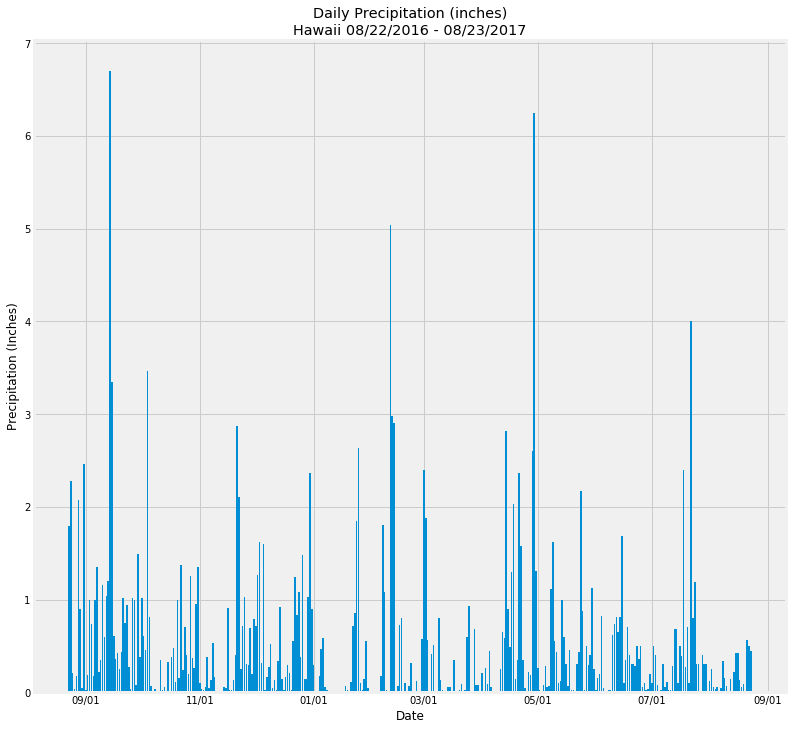

In [14]:
# matplotlibdate format modules
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# set parameters so all plots are consistent
plt.rcParams['figure.figsize'] = (12, 12)

# Define the date format
myFmt = DateFormatter("%m/%d") 

# plot the data
fig, ax = plt.subplots()
ax.bar(sorted_df.index.values, 
       sorted_df['prcp'].values)
ax.set(xlabel="Date", ylabel="Precipitation (Inches)")
ax.set(title=f"Daily Precipitation (inches)\nHawaii {dt.datetime.strftime(query_date, '%m/%d/%Y')} - {dt.datetime.strptime(max_date, '%Y-%m-%d').strftime('%m/%d/%Y')}")

# tell matplotlib to use the format specified above
ax.xaxis.set_major_formatter(myFmt); 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#ax.xaxis.set_minor_locator(mdates.DayLocator())

#plt.xticks(rotation=90)

![precipitation](Images/precipitation.png)

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [16]:
station_results = session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
            order_by(Station.id).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
station_df = pd.DataFrame(station_results)

sel = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurement_results = session.query(*sel).order_by(Measurement.id).all()
measurement_df = pd.DataFrame(measurement_results)



In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()


9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.id)]
session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*sel).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

In [20]:
sel = [Measurement.station, 
       func.count(Measurement.tobs)]
session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

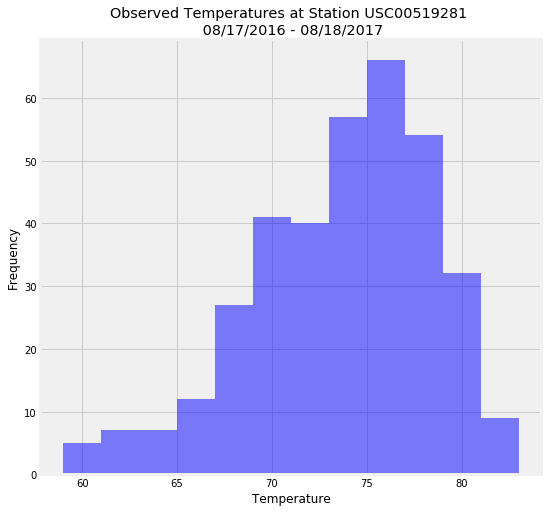

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
max_date = session.query(Measurement.date).filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()[0]
query_date = dt.datetime.strptime(max_date, '%Y-%m-%d')  - dt.timedelta(days=366)

# Perform a query to retrieve the data and tobs
results = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date >= query_date).\
            order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
x = df.tobs
num_bins = 12

plt.rcParams['figure.figsize'] = (8, 8)
n, bins, patches = plt.hist(x, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Observed Temperatures at Station USC00519281 \n {dt.datetime.strftime(query_date, '%m/%d/%Y')} - {dt.datetime.strptime(max_date, '%Y-%m-%d').strftime('%m/%d/%Y')}")
plt.show()


![precipitation](Images/station-histogram.png)

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2017-01-20', '2017-01-26')
print(my_trip)

[(67.0, 71.33333333333333, 77.0)]


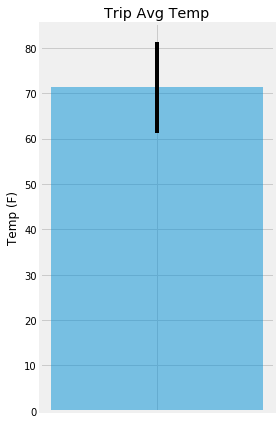

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Create lists for the plot

x_pos = np.arange(1)
avg_temp = [my_trip[0][1]]
error = [my_trip[0][2] - my_trip[0][0]]

# Build the plot
plt.rcParams['figure.figsize'] = (4, 6)

fig, ax = plt.subplots()
ax.bar(x_pos, avg_temp, yerr=error, alpha=0.5, ecolor='black', width=1)
ax.set_ylabel('Temp (F)')
ax.set_xticks(x_pos)
ax.set_xticklabels("")
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-01-20'
end_date = '2017-01-26'

sel = [Measurement.station,
       Station.name,
       func.sum(Measurement.prcp),
       Station.latitude,
       Station.longitude,
       Station.elevation]
session.query(*sel).filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).all()


[('USC00513117', 'KANEOHE 838.1, HI US', 0.4, 21.4234, -157.8015, 14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.03,
  21.5213,
  -157.8374,
  7.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  6.24,
  21.3331,
  -157.8025,
  152.4),
 ('USC00517948', 'PEARL CITY, HI US', 0.0, 21.3934, -157.9751, 11.9),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  1.05,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.23, 21.2716, -157.8168, 3.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.22999999999999998,
  21.33556,
  -157.71139,
  19.5)]

## Optional Challenge Assignment

In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.datetime.strptime('2020-01-20', '%Y-%m-%d')
end_date = dt.datetime.strptime('2020-01-26', '%Y-%m-%d')
date_list = []
date_strings = []

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
while start_date <= end_date:
    date_list.append(start_date)
    date_strings.append(start_date.strftime('%m') + '-' + start_date.strftime('%d'))
    start_date =  start_date + dt.timedelta(days=1)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for i in date_strings:
    normals.append(daily_normals(i))

normals

[[(61.0, 68.86666666666666, 78.0)],
 [(61.0, 70.14545454545454, 76.0)],
 [(60.0, 69.26415094339623, 76.0)],
 [(57.0, 69.50909090909092, 79.0)],
 [(58.0, 68.76271186440678, 78.0)],
 [(61.0, 67.94915254237289, 75.0)],
 [(61.0, 70.58620689655173, 77.0)]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
flat_list = [item for sublist in normals for item in sublist]

df = pd.DataFrame(index=date_list, data=flat_list, columns=['MinTemp', 'AvgTemp', 'MaxTemp'])
df.index.name = 'date'
df

,MinTemp,AvgTemp,MaxTemp
date,,,
2020-01-20,61.0,68.866667,78.0
2020-01-21,61.0,70.145455,76.0
2020-01-22,60.0,69.264151,76.0
2020-01-23,57.0,69.509091,79.0
2020-01-24,58.0,68.762712,78.0
2020-01-25,61.0,67.949153,75.0
2020-01-26,61.0,70.586207,77.0


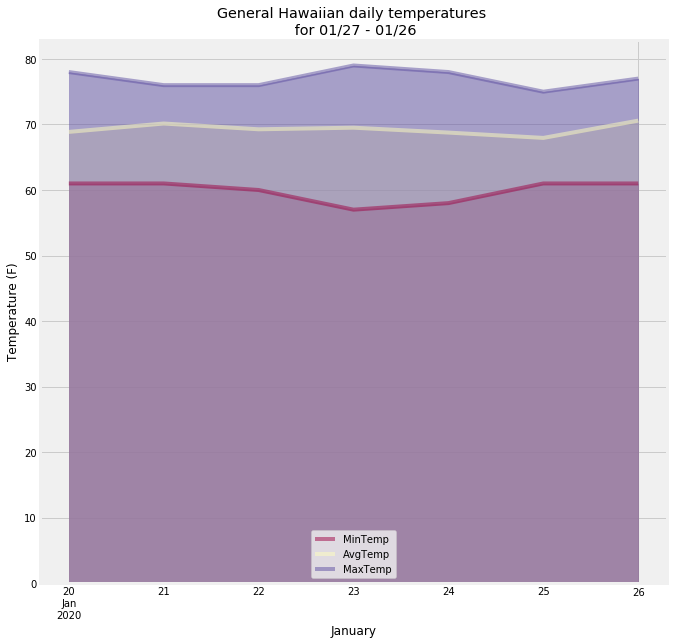

In [39]:
# Plot the daily normals as an area plot with `stacked=False`

plt.rcParams['figure.figsize'] = (10, 10)
df.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral',
        title=f"General Hawaiian daily temperatures \n for {dt.datetime.strftime(start_date, '%m/%d')} - {dt.datetime.strftime(end_date, '%m/%d')}")
plt.xlabel(f"{dt.datetime.strftime(start_date, '%B')}")
plt.ylabel('Temperature (F)')
[ax.legend(('MinTemp', 'AvgTemp', 'MaxTemp'),
           loc='lower center') for ax in plt.gcf().axes]
plt.show()